# Synthetic data generation: data exploration with BTYD data

## Introduction

Let's have a look at some typical data we may want to analyse with the "WISE MODEL" package.

"WISE MODEL" can generate some synthetic data for us, using the Buy-Till-You-Die (BTYD) class of models. The BTYD models assumes that a customer will continue to transact while they are alive, but at every transaction they have a fixed probability $p$ of "dying" (refered to as "churn" in the "WISE MODEL" model), after which they cease to interact with us. In this tutorial, we will be using the `BTYD` module from `neural_lifetimes.datasets`.

Each customer has a different value of $p$, sampled from a Beta distribution with parameters $a$ and $b$. Below is an image of a beta distribution with different values of $a=\alpha$ and $b=\beta$:

![Beta distribution image](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Beta_distribution_pdf.svg/325px-Beta_distribution_pdf.svg.png)


Each customer also has an individual value of $\lambda$ that controls the time between events, sampled from a Gamma distribution with parameters $r$ and $\alpha$. Below is an image of a gamma distribution with different $k=\alpha$ and $\theta = \frac1r$:

![Gamma distribution](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gamma_distribution_pdf.svg/325px-Gamma_distribution_pdf.svg.png)

We can set $a$, $b$, $r$ and $\alpha$ for a dataset to control the distributions of churn and the time between events.

We can also specify multiple modes for our dataset, for example if we'd like to model a situation where we have two different clusters of customers with different attributes. 

## Setup

Firstly, we need to generate some customer transactions to work with. To see the effect of changing our generation parameters, let's make four datasets, each with different parameter sets to control $p$ and $\lambda$. Let's also restrict to just 1000 customers for this toy example.

First, we create a dictionary with parameters that describe these four datasets:

In [1]:
num_customers = 1000
param_sets = {
    'balanced': {'a': 0.5, 'b': 2.5, 'alpha': 100, 'r': 0.25}, # mean p_churn = 0.2, mean lambda = 400 hrs = 16.7 days
    'low_p': {'a': 0.5, 'b': 20, 'alpha': 100, 'r': 0.25}, # mean p_churn = 0.05, mean lambda = 400 hrs = 16.7 days
    'high_p': {'a': 4, 'b': 1, 'alpha': 100, 'r': 0.25}, # mean p_churn = 0.8, mean lambda = 400 hrs = 16.7 days
    'long_intervals': {'a': 0.8, 'b': 2.5, 'alpha': 100, 'r': 0.0001} # mean p_churn = 0.32, mean lambda = 25 hrs
}

For the rest of of BTYD data parameters we'll use the defaults provided. These extra parameters include the start and end date we'll consider for our dataset, as well as the continuous and discrete features that each event might possess. In our default "customer & transactions" paradigm, we'll have features such as "TARGET_CURRENCY" & "FEE_VALUE_GDP" to describe each event.

In [2]:
import datetime

# Import BTYD synthetic model generation class
from neural_lifetimes.data.datasets import BTYD

# Import some additional default settings
import eventsprofiles_datamodel 

cont_feat = eventsprofiles_datamodel.cont_feat
discr_feat = eventsprofiles_datamodel.discr_feat

print(cont_feat) #These are the continuous features we consider
print(discr_feat) #These are the discrete features we consider

DATA_DIR = '../examples'

start_date, start_limit_date, end_date = datetime.date(2019, 1, 1), datetime.date(2019, 6, 1), datetime.date(2021, 1, 1)

#Now we generate datasets for each one of the settings in param_sets above. Note this is still unimodal.
datasets = {}
for key, params in param_sets.items():
    dataset = BTYD(
        num_customers=num_customers,
        a=params["a"],
        b=params["b"],
        r=params["r"],
        alpha=params["alpha"],
        data_dir=DATA_DIR,
        start_date=start_date,
        start_limit_date=start_limit_date,
        end_date=end_date,
        continuous_features=cont_feat,
        discrete_features=discr_feat,
        seq_gen_dynamic=False,  # when training, we set this to true to generate data dynamically to avoid overfitting
    )
    datasets[key] = dataset


print("Start_date:", start_date, "end_date:", end_date)

['INVOICE_VALUE_GBP_log', 'FEE_INVOICE_ratio', 'MARGIN_GBP', 'AGE_YEARS']
['ACTION_STATE', 'ACTION_TYPE', 'BALANCE_STEP_TYPE', 'BALANCE_TRANSACTION_TYPE', 'DESCRIPTION', 'PRODUCT_TYPE', 'SENDER_TYPE', 'SOURCE_CURRENCY', 'SUCCESSFUL_ACTION', 'TARGET_CURRENCY', 'ADDRESS_MARKET', 'ADDR_COUNTRY', 'BEST_GUESS_COUNTRY', 'CHANNEL', 'CNTRY_TARGET_RECIPIENT_FIRST', 'CREATION_PLATFORM', 'CUSTOMER_TYPE', 'FIRST_CCY_SEND', 'FIRST_CCY_TARGET', 'FIRST_VISIT_IP_COUNTRY', 'ISO3_COUNTRY_CODE', 'LANGUAGE', 'ORIGIN', 'SEG_QUESTION_PURPOSE']
Start_date: 2019-01-01 end_date: 2021-01-01


## Visualising a customer

Now that we have four different synthetic unimodal datasets to explore, we can take a look at one of our customer's transactions. We can directly access the transactions of the first customer in dataset "A" and view them on a timeline:

dict_keys(['t', 'INVOICE_VALUE_GBP_log', 'FEE_INVOICE_ratio', 'MARGIN_GBP', 'AGE_YEARS', 'ACTION_STATE', 'ACTION_TYPE', 'BALANCE_STEP_TYPE', 'BALANCE_TRANSACTION_TYPE', 'DESCRIPTION', 'PRODUCT_TYPE', 'SENDER_TYPE', 'SOURCE_CURRENCY', 'SUCCESSFUL_ACTION', 'TARGET_CURRENCY', 'ADDRESS_MARKET', 'ADDR_COUNTRY', 'BEST_GUESS_COUNTRY', 'CHANNEL', 'CNTRY_TARGET_RECIPIENT_FIRST', 'CREATION_PLATFORM', 'CUSTOMER_TYPE', 'FIRST_CCY_SEND', 'FIRST_CCY_TARGET', 'FIRST_VISIT_IP_COUNTRY', 'ISO3_COUNTRY_CODE', 'LANGUAGE', 'ORIGIN', 'SEG_QUESTION_PURPOSE', 'USER_PROFILE_ID', 'lambda', 'p', 'btyd_mode'])


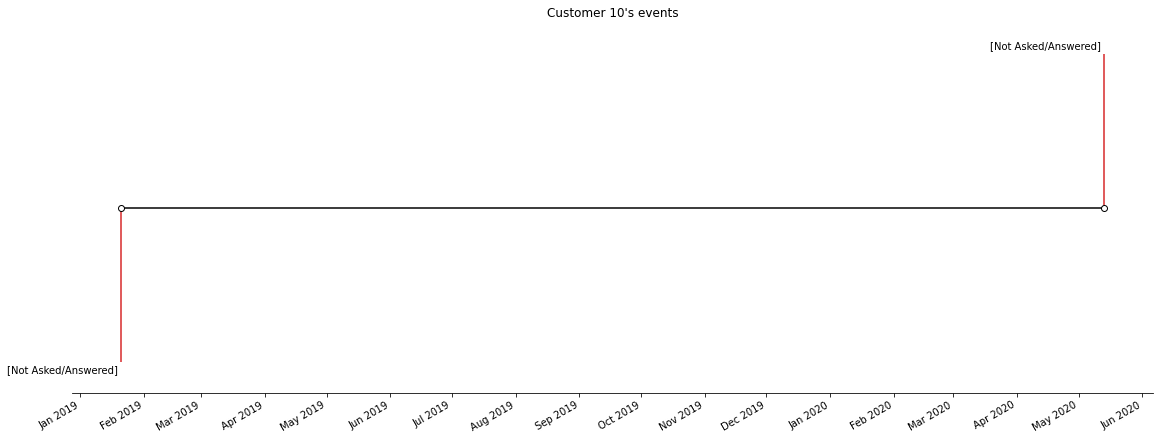

In [3]:
#Plotting functions
from neural_lifetimes.utils.plots import plot_timeline

# Let's look at one specific customer in our dataset. 
index = 10 #select customer 
# We need to get the attributes for customer "index"
sample_from_balanced = datasets["balanced"][index][0]

# Customer "index"'s attributes are stored in a dictionary where each value is a numpy array of values per transaction
# This includes all the continuous and discrete features
print(sample_from_balanced.keys())

# We should also get the transaction dates associated with these features
dates = sample_from_balanced['t']
names = sample_from_balanced["ACTION_STATE"]

_ = plot_timeline(dates, names, title = f"Customer {index}'s events")


As we'd expect, we can see that our customer has been transacting on fairly
regular basis until some time before the end_date, at which point we can suspect that they
"churned" - i.e. will not carry out any further transactions with us.

In this synthetic BTYD data, each of the "types" of each event is uniformly randomly generated. In real data, we'd hope to learn relationships between different event types and the times at which they occur.

## Multi-customer analysis

Now we have a better idea of what each customer is doing individually, let's explore some trends in our datasets.
To start with, let's look at the behaviour of the number of daily transactions over time. 

First, let's investigate the effect of `p_churn`. We get data from the `low_p` dataset:

<AxesSubplot:title={'center':'Number of transactions. Params : low_p (n=1000)'}, ylabel='# Transactions'>

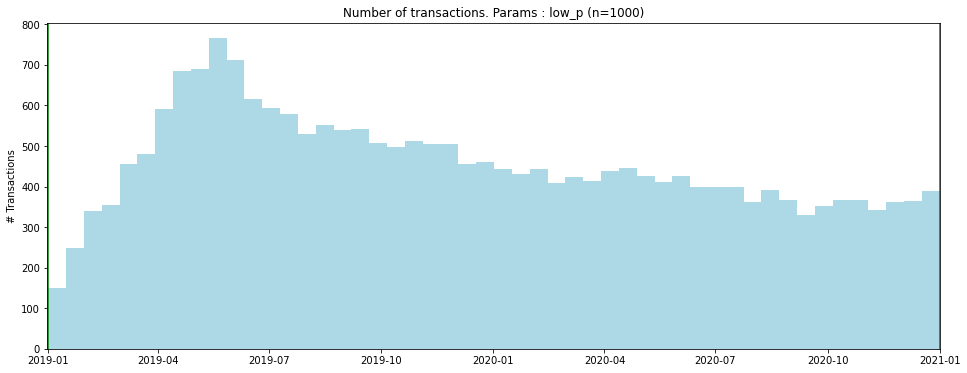

In [4]:
from neural_lifetimes.utils.plots import plot_transactions

#Get data for all customers
sample_from_lowp = datasets["low_p"][:]


title = lambda key : f"Number of transactions. Params : {key} (n={num_customers})"

plot_transactions(sample_from_lowp, year_limit=1, title=title("low_p"), start_date=start_date, end_date=end_date)




With a low average probability of churn, we see:
* The right tail tapers of very slowly $-$ many of our customers are still with us and they are 'dying' at a slow rate
* The absolute number of transactions (y-axis) is high compared to the other graphs (customers don't churn between bins)

Now let's perform the same exercise for a high `p_churn`:

<AxesSubplot:title={'center':'Number of transactions. Params : high_p (n=1000)'}, ylabel='# Transactions'>

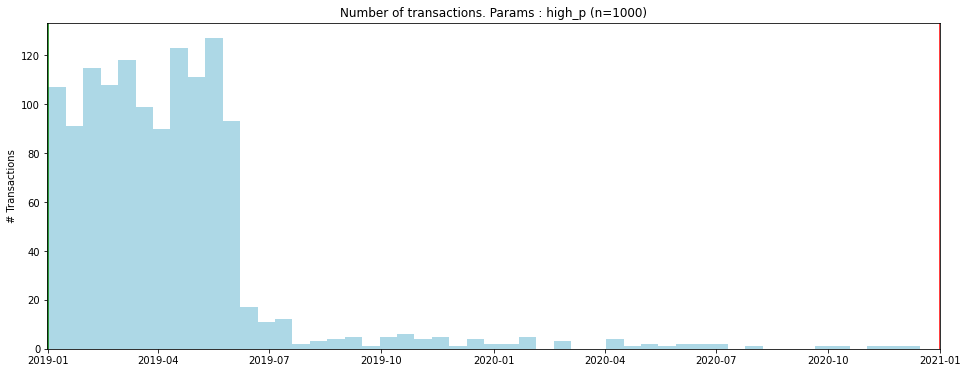

In [5]:
sample_from_highp = datasets["high_p"][:]

plot_transactions(sample_from_highp, year_limit=1, title=title("high_p"), start_date=start_date, end_date=end_date)


With a high average probability probability of churn, most of our customers have been assigned high probability of churn values and so have very few transactions before churning. As a consequence:
* Most of our customers have their last transaction near the start of the time frame $-$ there are very few transactions after `start_limit_date`.
* Most of our customers have 1 event before churning $-$ the absolute number of transactions is much lower compared to the above

Now, let's investigate the effect of `lambda` $-$ the parameter that sets the time interval between events. Let's get data from the dataset `long_intervals` and plot:

<AxesSubplot:title={'center':'Number of transactions. Params : long_intervals (n=1000)'}, ylabel='# Transactions'>

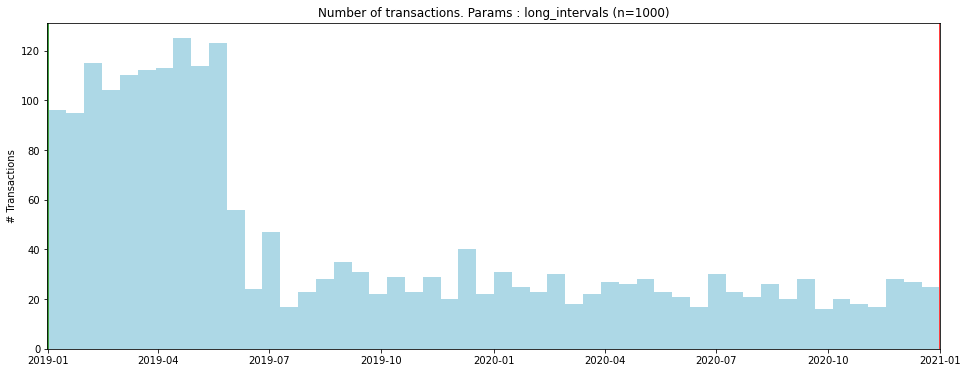

In [6]:
sample_from_longint = datasets["long_intervals"][:]

plot_transactions(sample_from_longint, year_limit=1, title=title("long_intervals"), start_date=start_date, end_date=end_date)



With high average lambda, most customers will spend a long time between transactions. As a consequence:
* Most customers will only have a few events in our dataset, and so we don't see any strong trends in number of transactions $-$ after `start_limit_date`, the number of transactions is stable
* The absolute number of transactions is quite low

Now let's look at our balanced dataset:

<AxesSubplot:title={'center':'Number of transactions. Params : balanced (n=1000)'}, ylabel='# Transactions'>

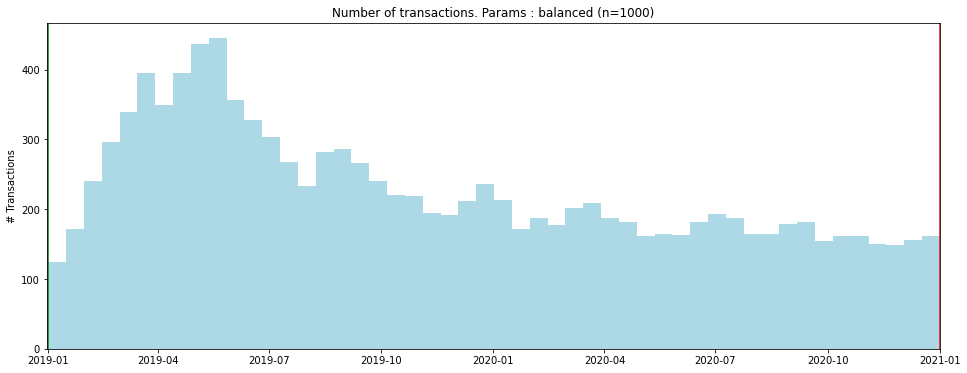

In [7]:
sample_from_balanced1 = datasets["balanced"][:]

plot_transactions(sample_from_balanced1, year_limit=1, title=title("balanced"), start_date=start_date, end_date=end_date)



With events on average every half a month and an average probability of churn of 0.32, we see some of our customers churning fairly on. However, a significant number of loyal customers keep interacting throughout our whole period. This is what we are likely to see for a real dataset.

## Multi-modal data

So far our synthetic data has consisted of customers all drawn from the same distribution. However, in live data we'd expect to encounter many different types of customer with different transactional patterns. We can simulate this with a multi-modal BTYD dataset.

### Setup

To construct this object, we could in theory pass in lists of parameters corresponding to each mode to our `BTYD` object from earlier. However, it is more natural to define the modes first before then using them to construct a multi-modal `BTYD` object.

To do this, we use the `GenMode` module. For each mode we can either specify the parameters $a$, $b$, $r$, $\alpha$ that we've seen in the uni-modal case, or pass the desired mean probability of churn and mean interval (which will then be converted into $a, b, r$ and $\alpha$ automatically). We can also give a distribution for any of the continuous or discrete features in our dataset. In the modes below, we give the `"PRODUCT_TYPE"` feature a constant distribution, and we give the `"INVOICE_VALUE_GBP_log"` feature a $Normal(\mu, \sigma^2$) distribution.

Let's construct a 'fast mode' for customers who use their cards, and a 'slow mode' for customers who use balance.

In [8]:
from neural_lifetimes.data.datasets.btyd import GenMode

fast_card_mode = GenMode(a = 1, b = 5, r = 1, alpha = 200, discrete_dist = { # mean lambda is 200
        "PRODUCT_TYPE":{
            "CARD": 1,
            "BALANCE": 0
        }
    }, cont_dist = {
            "INVOICE_VALUE_GBP_log": (-5,1)
        })

slow_balance_mode = GenMode(a = 1, b = 5, r = 100, alpha = 400000, discrete_dist = { # mean lambda is 4000
    "PRODUCT_TYPE":{
        "CARD": 0,
        "BALANCE": 1
    }}, cont_dist = {
        "INVOICE_VALUE_GBP_log": (5,1)
    }
)


We then pass these modes through the constructor `BTYD.from_modes` with the additional parameter `ratios` $-$ which determines how often we sample from each mode. This creates a multimodal dataset `mm_dataset`.

In [15]:
from neural_lifetimes.data.datasets import BTYD
from eventsprofiles_datamodel import cont_feat, discr_feat
from pathlib import Path

data_dir = str(Path().cwd().parent / 'examples')
num_customers = 10000
mm_dataset = BTYD.from_modes(
        num_customers=10000,
        modes=[fast_card_mode,slow_balance_mode],
        data_dir=data_dir,
        start_date=start_date,
        start_limit_date=start_limit_date,
        end_date=end_date,
        continuous_features=cont_feat,
        discrete_features=discr_feat,
        mode_ratios=[0.5,0.5],
        seq_gen_dynamic = False,
        track_statistics=True,
    )

### Single customer events

If we plot a single customer we'd expect to see that either all of their "PRODUCT_TYPE" events are either "CARD" or "BALANCE".

<AxesSubplot:title={'center':"Customer 8075's events"}>

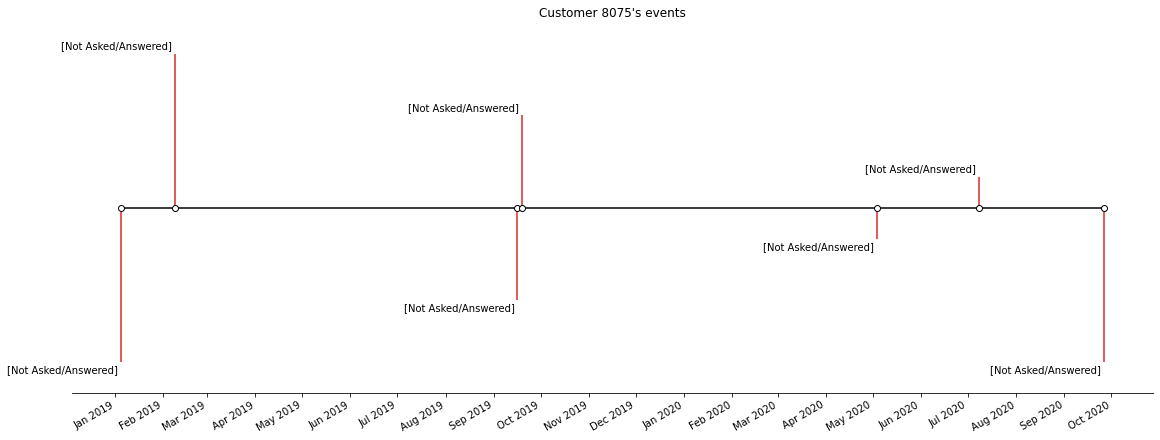

In [10]:
from neural_lifetimes.utils.plots import plot_timeline
import random 
index = random.randint(0, num_customers-1)
single_sample = mm_dataset[index][0]
dates = single_sample['t']
names = single_sample['PRODUCT_TYPE']

plot_timeline(dates, names, title = f"Customer {index}'s events")


Our prediction was validated. If we change the index, we'll see timelines for other users with "CARD" transactions too.

### Frequency of transactions
Let's look at the frequency of transactions next!

<AxesSubplot:title={'center':'Average # days between transaction by # customers (n=10000)'}, ylabel='# Customers'>

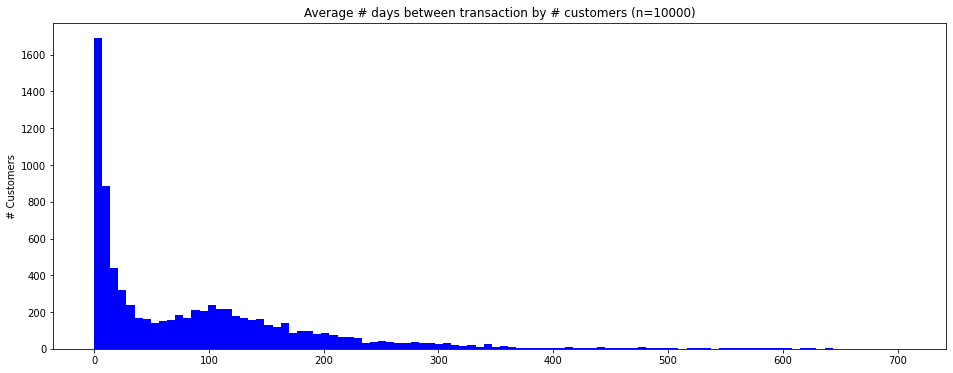

In [17]:
from neural_lifetimes.utils.plots import plot_freq_transactions

sample_mm = mm_dataset[:]

plot_freq_transactions(sample_mm)



We can see that our graph of number of transactions has two modes : one at 0 for our fast-transaction `"CARD"` customers and another around 100 for our slower-transaction `"BALANCE"` customers.

### Bimodal distribution of continuous features

Lastly, let's look at the distribution of one of our continuous features:

<AxesSubplot:title={'center':'Feature INVOICE_VALUE_GBP_log by # events (n=10000)'}, ylabel='# Events'>

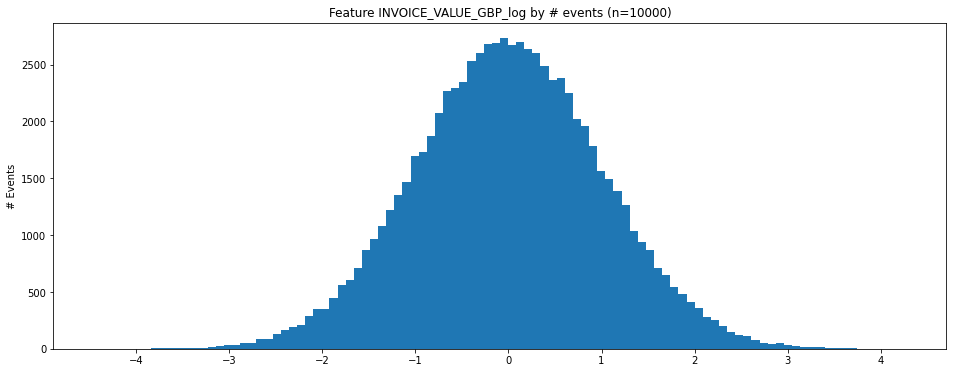

In [12]:
from neural_lifetimes.utils.plots import plot_cont_feature

feature = "INVOICE_VALUE_GBP_log"
plot_cont_feature(sample_mm, feature)

As we specified, we have a bimodal Normal distribution on the `"INVOICE_VALUE_GBP_log"` feature. We see different height peaks because the $Normal(-5,1)$ distribution is associated with the `fast_card_mode` - with lower chance of churn and smaller time intervals between events we'd expect to see more events in our dataset.

Nothing we've shown here is restricted to a bimodal dataset - specifying and passing more modes to the `BTYD` constructor will result in more complex multi-modal datasets that can more closely mirror real data.

### Built-in BTYD plots
The BTYD dataset has a built-in plotting functionality based on `plotly`.

In [18]:
import plotly.io as pio
# open the plot panel in browser window instead of plotting it inline
pio.renderers.default = 'browser'

# launch plots 
mm_dataset.plot_tracked_statistics().show()